In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score
from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV
from sklearn.metrics import roc_auc_score
# 特征最影响结果的K个特征
from sklearn.feature_selection import SelectKBest

# 卡方检验，作为SelectKBest的参数
from sklearn.feature_selection import chi2
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler

data = pd.read_csv('汇总.csv', encoding='GB2312')

In [17]:
print(data.columns)

Index(['患者ID号', '钙', '钠', '低密度脂蛋白胆固醇', '血小板', '血小板分布宽度', '血小板压积', '中性粒细胞百分比',
       '中性粒细胞绝对值', '平均血小板体积', '大血小板比率', '红细胞', '手术时长', 'age', 'gender', '麻醉方式',
       'asa分级', '身高', '体重', '血压/高', '血压/低', '白细胞', 'ALT', '肾小球滤过率', '肌酐', 'K',
       '尿酸', '血糖', '总胆红素', '是否吸烟', '是否饮酒', '是否有手术史', '心脏病', '高血压', '糖尿病',
       'label'],
      dtype='object')


In [18]:
data_f = shuffle(data)
X = data_f[['钙', '钠', '低密度脂蛋白胆固醇', '血小板', '血小板分布宽度', '血小板压积', '中性粒细胞百分比',
       '中性粒细胞绝对值', '平均血小板体积', '大血小板比率', '红细胞', '手术时长', 'age', 'gender', '麻醉方式',
       'asa分级', '身高', '体重', '血压/高', '血压/低', '白细胞', 'ALT', '肾小球滤过率', '肌酐', 'K',
       '尿酸', '血糖', '总胆红素', '是否吸烟', '是否饮酒', '是否有手术史', '高血压', '心脏病', '糖尿病']]
y = data_f['label']

scaler = MinMaxScaler(feature_range=(0, 1))
X_ = scaler.fit_transform(X)
df = pd.DataFrame(X_)

bestfeatures = SelectKBest(score_func=chi2, k=len(df.columns))
fit = bestfeatures.fit(X_, y)

## 'age', '是否吸烟', 'asa分级', '是否饮酒', '是否有手术史', 'gender', '肾小球滤过率', '血压/高', '血小板压积', '血小板'

df_scores = pd.DataFrame(fit.scores_)

df_columns = pd.DataFrame(X.columns)

# 合并两个df
df_feature_scores = pd.concat([df_columns,df_scores],axis=1)
# 列名
df_feature_scores.columns = ['feature_name','Score']

df_feature_scores.sort_values(by="Score", ascending=False)

,feature_name,Score
31,高血压,566.402559
32,心脏病,538.457112
33,糖尿病,290.439636
12,age,109.657273
15,asa分级,81.609376
28,是否吸烟,75.810351
29,是否饮酒,68.358747
30,是否有手术史,44.324348
13,gender,37.312446
22,肾小球滤过率,23.019955


### SVM

In [19]:
X = data_f[['中性粒细胞绝对值', 'age', 'asa分级', '是否吸烟', '心脏病', '高血压', '糖尿病']]
# X = data_f[['age', 'gender', 'asa分级', '肾小球滤过率', '是否吸烟', 
#             '是否饮酒', '是否有手术史', '高血压', '心脏病', '糖尿病']]
y = data_f['label']

scaler = StandardScaler()
X_ = scaler.fit_transform(X)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.2, random_state=42)
# 创建SVM模型
svm_model = SVC(kernel='rbf', coef0 = 0.1, C = 100, gamma = 0.001, probability=True)
svm_model.fit(X_train, y_train)
# 在测试集上进行预测
y_pred = svm_model.predict(X_test)

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print("accuracy: ", accuracy)

rocauc_1 = roc_auc_score(y_test, svm_model.predict_proba(X_test)[:,1])
print("auc: ", rocauc_1)

accuracy:  0.7796024200518582
auc:  0.8573586237423585


### LR

In [20]:
from sklearn.linear_model import LogisticRegression

X = data_f[['中性粒细胞绝对值', 'age', 'asa分级', '是否吸烟', '心脏病', '高血压', '糖尿病']]
y = data_f['label']

scaler = StandardScaler()
X_ = scaler.fit_transform(X)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.2, random_state=42)
# 创建SVM模型
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
# 在测试集上进行预测
y_pred = lr_model.predict(X_test)

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print("accuracy: ", accuracy)

rocauc_1 = roc_auc_score(y_test, lr_model.predict_proba(X_test)[:,1])
print("auc: ", rocauc_1)

accuracy:  0.7873811581676751
auc:  0.8553278541434878


### DecisionTree

In [21]:
from sklearn.ensemble import RandomForestClassifier

X = data_f[['钙', '钠', '低密度脂蛋白胆固醇', '血小板', '血小板分布宽度', '血小板压积', '中性粒细胞百分比',
       '中性粒细胞绝对值', '平均血小板体积', '大血小板比率', '红细胞', '手术时长', 'age', 'gender', '麻醉方式',
       'asa分级', '身高', '体重', '血压/高', '血压/低', '白细胞', 'ALT', '肾小球滤过率', '肌酐', 'K',
       '尿酸', '血糖', '总胆红素', '是否吸烟', '是否饮酒', '是否有手术史', '高血压', '心脏病', '糖尿病']]

scaler = StandardScaler()
X_ = scaler.fit_transform(X)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.2, random_state=42)

# 创建随机森林分类器
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
# 使用训练集训练模型
rf_model.fit(X_train, y_train)

# 获取特征重要性
feature_importances = rf_model.feature_importances_

# 将特征重要性与特征名对应起来
feature_names = X.columns
df_feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# 按重要性降序排列
df_feature_importances = df_feature_importances.sort_values(by = 'Importance', ascending = False)

# 打印特征重要性
print(df_feature_importances)

      Feature  Importance
12        age    0.155183
15      asa分级    0.085682
22     肾小球滤过率    0.048320
31        高血压    0.046240
11       手术时长    0.035039
32        心脏病    0.032493
26         血糖    0.031791
6    中性粒细胞百分比    0.029505
10        红细胞    0.029394
0           钙    0.028970
24          K    0.028629
18       血压/高    0.027760
20        白细胞    0.027074
27       总胆红素    0.026587
7    中性粒细胞绝对值    0.026453
25         尿酸    0.025911
2   低密度脂蛋白胆固醇    0.025185
23         肌酐    0.024860
17         体重    0.024737
9      大血小板比率    0.024613
3         血小板    0.024325
1           钠    0.023725
4     血小板分布宽度    0.022938
16         身高    0.022602
19       血压/低    0.021828
21        ALT    0.021658
5       血小板压积    0.021410
8     平均血小板体积    0.019694
14       麻醉方式    0.011875
33        糖尿病    0.010500
13     gender    0.004309
29       是否饮酒    0.003621
30     是否有手术史    0.003580
28       是否吸烟    0.003509


In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

X = data_f[['中性粒细胞绝对值', 'age', 'asa分级', '是否吸烟', '心脏病', '高血压', '糖尿病']]
#X = data_f[['age', 'asa分级', '高血压']]
y = data_f['label']

scaler = StandardScaler()
X = scaler.fit_transform(X)

dt_model = DecisionTreeClassifier(random_state=42)
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
dt_model.fit(X_train, y_train)
# 在测试集上进行预测
y_pred = dt_model.predict(X_test)

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print("accuracy: ", accuracy)

rocauc_1 = roc_auc_score(y_test, dt_model.predict_proba(X_test)[:,1])
print("auc: ", rocauc_1)

accuracy:  0.7104580812445981
auc:  0.7114228546818362


### AdaBoost

In [23]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import MinMaxScaler

X = data_f[['中性粒细胞绝对值', 'age', 'asa分级', '是否吸烟', '心脏病', '高血压', '糖尿病']]
y = data_f['label']

# scaler = StandardScaler()
# X_ = scaler.fit_transform(X)
scaler = MinMaxScaler()
X_ = scaler.fit_transform(X)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.2, random_state=42)

# 创建 AdaBoost 分类器
ada_model = AdaBoostClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

ada_model.fit(X_train, y_train)

'''scores = cross_val_score(model, X_, y, cv = 10, scoring = 'accuracy')
print(scores)
print(np.mean(scores))'''

# 在测试集上进行预测
y_pred = ada_model.predict(X_test)

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print("accuracy: ", accuracy)

rocauc_1 = roc_auc_score(y_test, ada_model.predict_proba(X_test)[:,1])
print("auc: ", rocauc_1)

accuracy:  0.7865168539325843
auc:  0.8591486319970331


### KNN

In [24]:
from sklearn.neighbors import KNeighborsClassifier
X = data_f[['中性粒细胞绝对值', 'age', 'asa分级', '是否吸烟', '心脏病', '高血压', '糖尿病']]
#X = data_f[['age', 'asa分级', '高血压']]
y = data_f['label']

scaler = StandardScaler()
X = scaler.fit_transform(X)

knn_model = KNeighborsClassifier()
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
knn_model.fit(X_train, y_train)
# 在测试集上进行预测
y_pred = knn_model.predict(X_test)

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print("accuracy: ", accuracy)

rocauc_1 = roc_auc_score(y_test, knn_model.predict_proba(X_test)[:,1])
print("auc: ", rocauc_1)

accuracy:  0.7640449438202247
auc:  0.8144193613992272


### 高斯

In [25]:
from sklearn.naive_bayes import GaussianNB

gnb_model = GaussianNB()

gnb_model.fit(X_train, y_train)
# 在测试集上进行预测
y_pred = gnb_model.predict(X_test)

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print("accuracy: ", accuracy)

rocauc_1 = roc_auc_score(y_test, gnb_model.predict_proba(X_test)[:,1])
print("auc: ", rocauc_1)

accuracy:  0.766637856525497
auc:  0.8401494215746091


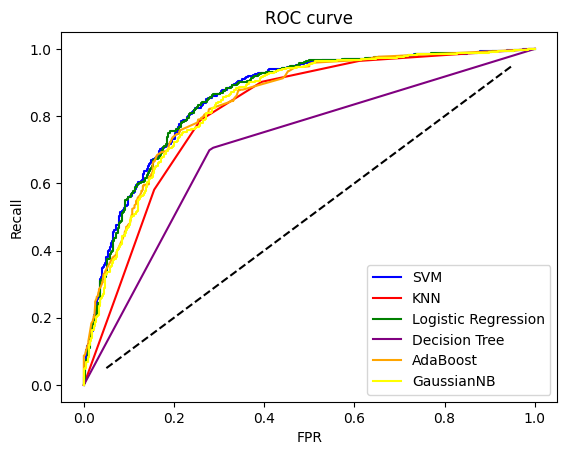

In [26]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

FPR, recall, thresholds = roc_curve(y_true=y_test,  # 真实标签是
                                    y_score=svm_model.decision_function(X_test),  # 置信度，也可以是概率值
                                    pos_label=1)  # 正样本标签是1
#print(FPR.shape)  # 得到了每一个阈值下的 FPR 数组
#print(recall.shape)  # 得到了每一个阈值下的 Recall 数组
#print(thresholds.shape)  # 如果y_score使用的是距离，那么thresholds也是距离；如果y_score使用的是概率，那么thresholds也是概率
plt.figure()
plt.plot(np.linspace(0.05, 0.95, 40), np.linspace(0.05, 0.95, 40), c='black', linestyle='--')#参考线
plt.plot(FPR, recall, c='blue', label='SVM')  # ROC 曲线
prob = knn_model.predict_proba(X_test)
prob = pd.DataFrame(prob)
prob.columns = ['0', '1']
FPR, recall, thresholds = roc_curve(y_true=y_test,  # 真实标签是
                                    y_score=prob.loc[:, '1'],  # 置信度，也可以是概率值
                                    pos_label=1)  # 正样本标签是1
plt.plot(FPR, recall, c='red', label='KNN')  # ROC 曲线
FPR, recall, thresholds = roc_curve(y_true=y_test,  
                                    y_score=lr_model.decision_function(X_test),  
                                    pos_label=1)  
plt.plot(FPR, recall, c='green', label='Logistic Regression') 
prob = dt_model.predict_proba(X_test)
prob = pd.DataFrame(prob)
prob.columns = ['0', '1']
FPR, recall, thresholds = roc_curve(y_true=y_test,  
                                    y_score=prob.loc[:, '1'],  
                                    pos_label=1)  
plt.plot(FPR, recall, c='purple', label='Decision Tree')  
FPR, recall, thresholds = roc_curve(y_true=y_test,  #
                                    y_score=ada_model.decision_function(X_test),  
                                    pos_label=1)  
plt.plot(FPR, recall, c='orange', label='AdaBoost')  
prob = gnb_model.predict_proba(X_test)
prob = pd.DataFrame(prob)
prob.columns = ['0', '1']
FPR, recall, thresholds = roc_curve(y_true=y_test,  
                                    y_score=prob.loc[:, '1'],  
                                    pos_label=1) 
plt.plot(FPR, recall, c='yellow', label='GaussianNB')  


plt.title('ROC curve')  # 设置标题
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('FPR')
plt.ylabel('Recall')
plt.legend(loc='lower right')
plt.savefig('ROC curve.png')
plt.show()

# 计算AUC面积
#from sklearn.metrics import roc_auc_score

#auc = roc_auc_score(y_true=y_test,  # 真实标签是
                    #y_score=clf.decision_function(X_test))  # 置信度，也可以是概率值
#print(auc)

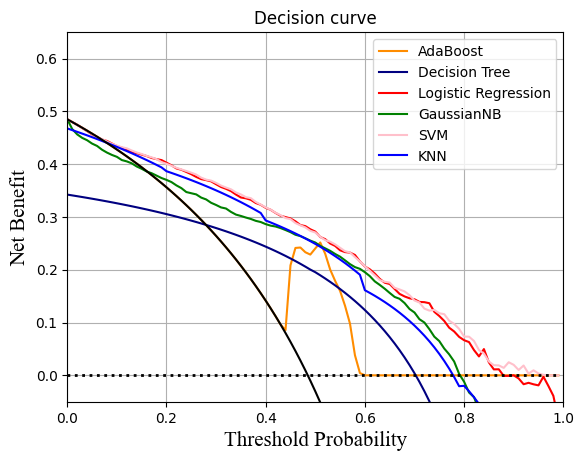

In [27]:
from sklearn.metrics import confusion_matrix
models = [('AdaBoost', ada_model),
          ('Decision Tree', dt_model),
          ('Logistic Regression', lr_model),
          ('GaussianNB', gnb_model),
          ('SVM',svm_model),
          ('KNN',knn_model)
        ]

#models = [
 #       ('SVC',SVC(probability=True))
 #       ]
 
def net_benefit_model(y_test,y_prob,thresh_group):
    total = y_test.shape[0]
    net_model = np.array([])
    for thresh in thresh_group:
        y_pred = y_prob > thresh
        tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
        net_benefit = tp/total-fp/total*(thresh/(1-thresh))
        net_model = np.append(net_model,net_benefit)
    return net_model
 
def net_benefit_all(y_test,thresh_group):
    tn, fp, fn, tp = confusion_matrix(y_test,y_test).ravel()
    total = y_test.shape[0]
    net_all = np.array([])
    for thresh in thresh_group:
        net_benefit = (tp)/total - (tn)/total*(thresh/(1-thresh))
        net_all = np.append(net_all, net_benefit)
    return net_all
 
thresh_group = []
for i in range(0,100,1):
    thresh = i/100
    thresh_group.append(thresh)
 
color = ["darkorange","navy","red","green","pink",'blue']
a = 0
benefit_all = net_benefit_all(y_test,thresh_group)
benefit_models = []
y2 = np.maximum(benefit_all, 0)
plt.xlim(0,1)
 
for name,model in models:
    clf = model
    y_prob = clf.predict_proba(X_test)[:,1]
    benefit_model = net_benefit_model(y_test,y_prob,thresh_group)
    plt.plot(thresh_group,benefit_model,color = color[a],label = name)
    #y1 = np.maximum(benefit_model, y2)
    #plt.fill_between(thresh_group, y1, y2, facecolor= color [a], alpha=0.3 )
    a = a + 1
    benefit_models.append(benefit_model)
 
    
plt.plot(thresh_group,benefit_all,color = 'black')
plt.plot(thresh_group,np.zeros(len(thresh_group)),color = 'k',lw = 2, linestyle = ':')
 
plt.ylim(-0.05,0.65)#ylim(ymin,ymax)可以修改坐标轴的范围
plt.xlabel(
    xlabel = 'Threshold Probability', 
    fontdict= {'family': 'Times New Roman', 'fontsize': 15}
)
plt.ylabel(
    ylabel = 'Net Benefit', 
    fontdict= {'family': 'Times New Roman', 'fontsize': 15}
)
#plt.figure(figsize=(10, 10))
plt.grid('major')
#plt.spines['right'].set_color((0.8, 0.8, 0.8))
#plt.spines['top'].set_color((0.8, 0.8, 0.8))
plt.legend(loc = 'upper right')
plt.title('Decision curve')
plt.savefig('Decision curve.png')
plt.show()

### 校准曲线

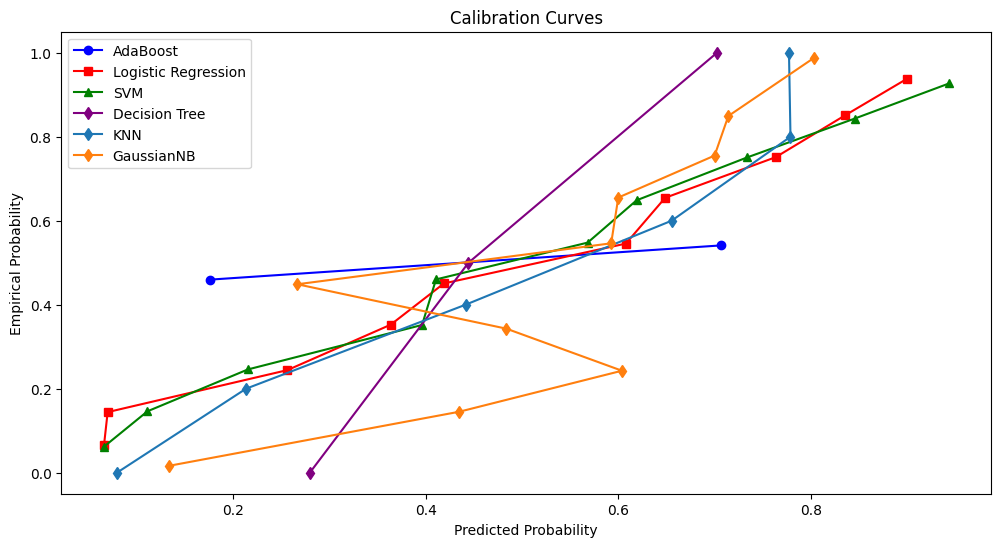

In [28]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# 预测概率
ada_pred_proba = ada_model.predict_proba(X_test)[:, 1]
lr_pred_proba = lr_model.predict_proba(X_test)[:, 1]
svm_pred_proba = svm_model.predict_proba(X_test)[:, 1]
tree_pred_proba = dt_model.predict_proba(X_test)[:, 1]
knn_pred_proba = knn_model.predict_proba(X_test)[:, 1]
gnb_pred_proba = gnb_model.predict_proba(X_test)[:, 1]

# 计算每个模型的校准曲线
n_bins = 10
ada_curve = calibration_curve(y_test, ada_pred_proba, n_bins=n_bins)
lr_curve = calibration_curve(y_test, lr_pred_proba, n_bins=n_bins)
svm_curve = calibration_curve(y_test, svm_pred_proba, n_bins=n_bins)
tree_curve = calibration_curve(y_test, tree_pred_proba, n_bins=n_bins)
knn_curve = calibration_curve(y_test, knn_pred_proba, n_bins=n_bins)
gnb_curve = calibration_curve(y_test, gnb_pred_proba, n_bins=n_bins)

# 解包校准曲线的返回值
ada_mean_pred, ada_mean_true = ada_curve
lr_mean_pred, lr_mean_true = lr_curve
svm_mean_pred, svm_mean_true = svm_curve
tree_mean_pred, tree_mean_true = tree_curve
knn_mean_pred, knn_mean_true = knn_curve
gnb_mean_pred, gnb_mean_true = gnb_curve

# 绘制校准曲线
plt.figure(figsize=(12, 6))

# 绘制AdaBoost校准曲线
plt.plot(ada_mean_pred, ada_mean_true, marker='o', label='AdaBoost', color='blue')

# 绘制逻辑回归校准曲线
plt.plot(lr_mean_pred, lr_mean_true, marker='s', label='Logistic Regression', color='red')

# 绘制SVM校准曲线
plt.plot(svm_mean_pred, svm_mean_true, marker='^', label='SVM', color='green')

# 绘制决策树校准曲线
plt.plot(tree_mean_pred, tree_mean_true, marker='d', label='Decision Tree', color='purple')

plt.plot(knn_mean_pred, knn_mean_true, marker='d', label='KNN')

plt.plot(gnb_mean_pred, gnb_mean_true, marker='d', label='GaussianNB')

plt.xlabel('Predicted Probability')
plt.ylabel('Empirical Probability')
plt.title('Calibration Curves')
plt.legend()
plt.savefig('Calibration Curves.png')
plt.show()